In [1]:
import json
import sys
sys.path.append('/Users/wastechs/Documents/git-repos/energy-efficiency')
from validation.gp.create_train_inference import create_train_inference_gp
from lib.util import helper, data_preprocessing
import torch
import gpytorch

### 30 minutes agg.

In [2]:
X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='gesamtmessung_30T', 
    freq=30,
    normalize_time=True
    )

In [3]:
## Locally Periodic Kernel ##
period_constraint_short = gpytorch.constraints.Interval(0.06, 0.10) ## short term

seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_short
        )
    )

seasonal_rbf_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_short_periodic = seasonal_periodic_short * seasonal_rbf_short

period_constraint_long = gpytorch.constraints.Interval(0.20, 0.23) ## long term

seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_long
        )
    )

seasonal_rbf_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_long_periodic = seasonal_periodic_long * seasonal_rbf_long

## Local Variations ##
local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

local_variation = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RQKernel()
    )
    
local_variation.alpha = local_variation_alpha

local_variation_2 = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
    )


covar_module = locally_short_periodic + locally_long_periodic + local_variation #+ local_variation_2

### Create, Train, and Perform Inference

Iter 1 , Loss = 1.025874317628516 , Noise = 0.6932471990585327
Iter 2 , Loss = 0.9877774854733379 , Noise = 0.6444966793060303
Iter 3 , Loss = 0.9511524381341689 , Noise = 0.5982140898704529
Iter 4 , Loss = 0.9155065931982658 , Noise = 0.5543724894523621
Iter 5 , Loss = 0.8804251001450933 , Noise = 0.5129377841949463
Iter 6 , Loss = 0.8456298649033234 , Noise = 0.4738697409629822
Iter 7 , Loss = 0.8114146680362501 , Noise = 0.4371214509010315
Iter 8 , Loss = 0.7788794621905971 , Noise = 0.40263909101486206
Iter 9 , Loss = 0.7480193274955141 , Noise = 0.3703683018684387
Iter 10 , Loss = 0.7179749003275134 , Noise = 0.340253621339798
Iter 11 , Loss = 0.6885260205659521 , Noise = 0.3122313916683197
Iter 12 , Loss = 0.6593897109966834 , Noise = 0.28622961044311523
Iter 13 , Loss = 0.6309939143990168 , Noise = 0.2621679902076721
Iter 14 , Loss = 0.6039401885094573 , Noise = 0.23996157944202423
Iter 15 , Loss = 0.5774779049478594 , Noise = 0.21952375769615173
Iter 16 , Loss = 0.5504197135233

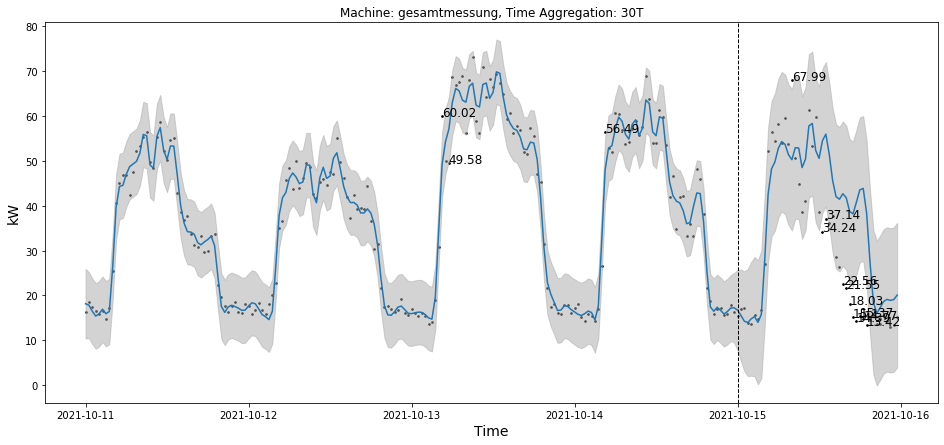

gesamtmessung
-----------------------------------
Expected next day energy consumption    =  884.5767938944809 kWh
Upper bound next day energy consumption =  1250.929545927237 kWh
Lower bound next day energy consumption =  518.224041861725 kWh


Abnormal High Energy Consumption
---------------------------------
2021-10-13 04:30:00 60.02493361340412
2021-10-14 04:30:00 56.487998194965606
2021-10-15 08:00:00 67.98935102352677


Abnormal Low Energy Consumption
---------------------------------
2021-10-13 05:30:00 49.58454603662293
2021-10-15 12:30:00 34.24192805101276
2021-10-15 13:00:00 37.13972328657887
2021-10-15 15:30:00 22.564208695847746
2021-10-15 16:00:00 21.5516307289306
2021-10-15 16:30:00 18.02637500516951
2021-10-15 17:00:00 15.102879558847071
2021-10-15 17:30:00 14.387216617004789
2021-10-15 18:00:00 15.374839049741514
2021-10-15 18:30:00 14.774898031047243
2021-10-15 19:00:00 13.422571324851866


In [4]:
model, likelihood, mse, mape, perf_dev_upper = create_train_inference_gp(
    kernel_gen=covar_module,
    train_x=X_train,
    train_y=y_train,
    test_x=X_test,
    test_y=y_test,
    n_train=n_train,
    time_agg='30T',
    machine='gesamtmessung',
    update_score=False
)

In [ ]:
for time, val in perf_dev_upper.items():
    print(time, val)

In [ ]:
model.state_dict()

In [33]:
mse, mape

(158.4009191816775, 0.43456210912706345)

### 10 minutes agg.

In [26]:
X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='gesamtmessung_10T', 
    freq=10,
    normalize_time=True
    )

In [27]:
## Locally Periodic Kernel ##
period_constraint_short = gpytorch.constraints.Interval(0.07, 0.10) ## short term

seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_short
        )
    )

seasonal_rbf_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_short_periodic = seasonal_periodic_short * seasonal_rbf_short

period_constraint_long = gpytorch.constraints.Interval(0.19, 0.21) ## long term

seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_long
        )
    )

seasonal_rbf_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_long_periodic = seasonal_periodic_long * seasonal_rbf_long

## Local Variations ##
local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

local_variation = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RQKernel()
    )
    
local_variation.alpha = local_variation_alpha


covar_module = locally_short_periodic + locally_long_periodic + local_variation

Iter 1 , Loss = 0.9195603535924936 , Noise = 0.6932471990585327
Iter 2 , Loss = 0.8852495454767831 , Noise = 0.6444966793060303
Iter 3 , Loss = 0.8511982114698594 , Noise = 0.5982182621955872
Iter 4 , Loss = 0.8168954774559934 , Noise = 0.5543885827064514
Iter 5 , Loss = 0.7829059502999924 , Noise = 0.512975811958313
Iter 6 , Loss = 0.7495759032025986 , Noise = 0.47394123673439026
Iter 7 , Loss = 0.7165462124940888 , Noise = 0.4372396171092987
Iter 8 , Loss = 0.6836808496825687 , Noise = 0.402817040681839
Iter 9 , Loss = 0.6514671752671396 , Noise = 0.37061306834220886
Iter 10 , Loss = 0.6204466916040814 , Noise = 0.340565025806427
Iter 11 , Loss = 0.5906962669337652 , Noise = 0.31260859966278076
Iter 12 , Loss = 0.5620534433910684 , Noise = 0.2866746783256531
Iter 13 , Loss = 0.5344317940158037 , Noise = 0.26268714666366577
Iter 14 , Loss = 0.5077333903502073 , Noise = 0.2405632883310318
Iter 15 , Loss = 0.48176712758346935 , Noise = 0.2202148586511612
Iter 16 , Loss = 0.4564892899526

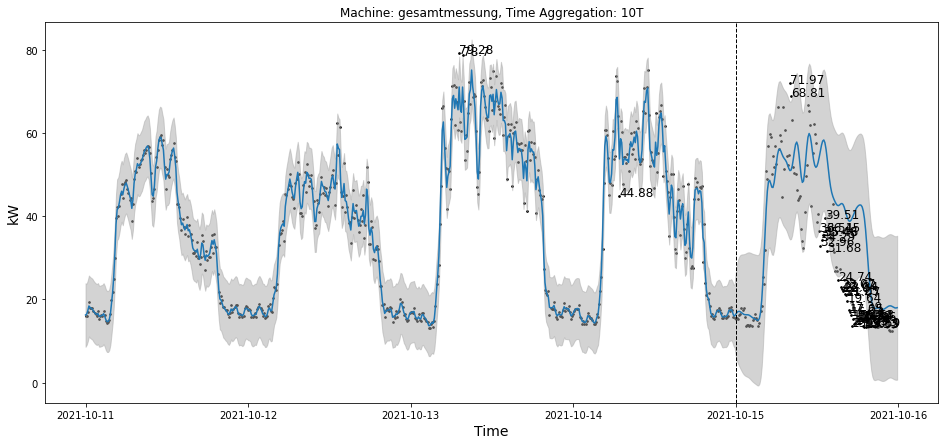

Paper Disposal Machine (Entsorgung)
-----------------------------------
Expected next day energy consumption    =  tensor(2697.5541, dtype=torch.float64) kWh
Upper bound next day energy consumption =  tensor(3883.6899, dtype=torch.float64) kWh
Lower bound next day energy consumption =  tensor(1511.4184, dtype=torch.float64) kWh


In [28]:
model, likelihood, mse, mape, perf_dev_upper = create_train_inference_gp(
    kernel_gen=covar_module,
    train_x=X_train,
    train_y=y_train,
    test_x=X_test,
    test_y=y_test,
    n_train=n_train,
    training_iter=100,
    lr=0.1,
    time_agg='10T',
    machine='gesamtmessung',
    update_score=True
)

In [29]:
mse, mape

(169.35436166883744, 0.4450852125290209)